# ANALYSIS:

In [19]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from datetime import date
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps


# statistical tests:
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [20]:
clean_data = pd.read_csv('project-data/clean_cahoots_envs_data.csv')

clean_data.head()

,Date,inci_id,nature,AQI,AQI_Category,tempmax,tempmin,precip,snow,daily calls,extreme heat,extreme cold,snow event,ice event,AQI hazard
0,2014-01-01,14000107,TRANSPORT,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
1,2014-01-01,14000382,TRANSPORT,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
2,2014-01-01,14000408,TRANSPORT,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
3,2014-01-01,14000414,WELFARE CHECK,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0
4,2014-01-01,14000416,SUBJECT DOWN,122,Unhealthy for Sensitive Groups,39.0,30.0,0.0,0.0,24,0,0,0,0,0


In [21]:
# MAKE SURE Date column in clean_data is DATETIME
if not pd.api.types.is_datetime64_any_dtype(clean_data['Date']):
    clean_data['Date'] = pd.to_datetime(clean_data['Date'])

# DAILY SUMMARY grouped dataframe
daily = clean_data.groupby('Date').agg({'daily calls': 'first', 'inci_id': 'first', 'extreme heat': 'max', 'extreme cold': 'min', 
                                      'snow': 'max', 'precip': 'max', 
                                      'snow event': 'max', 'ice event': 'max', 'AQI hazard': 'max',
                                      'tempmax': 'mean', 'tempmin': 'mean', 'AQI': 'mean'}).reset_index()

daily.head()

,Date,daily calls,inci_id,extreme heat,extreme cold,snow,precip,snow event,ice event,AQI hazard,tempmax,tempmin,AQI
0,2014-01-01,24,14000107,0,0,0.0,0.000,0,0,0,39.0,30.0,122.0
1,2014-01-02,21,14000811,0,0,0.0,0.000,0,0,0,49.4,34.1,80.0
2,2014-01-03,22,14001667,0,0,0.0,0.019,0,0,0,48.3,33.8,71.0
3,2014-01-04,20,14002413,0,1,0.0,0.000,0,0,0,39.4,26.7,77.0
4,2014-01-05,34,14003118,0,1,0.0,0.000,0,0,0,38.1,26.3,127.0


## 1. Time Series Overview

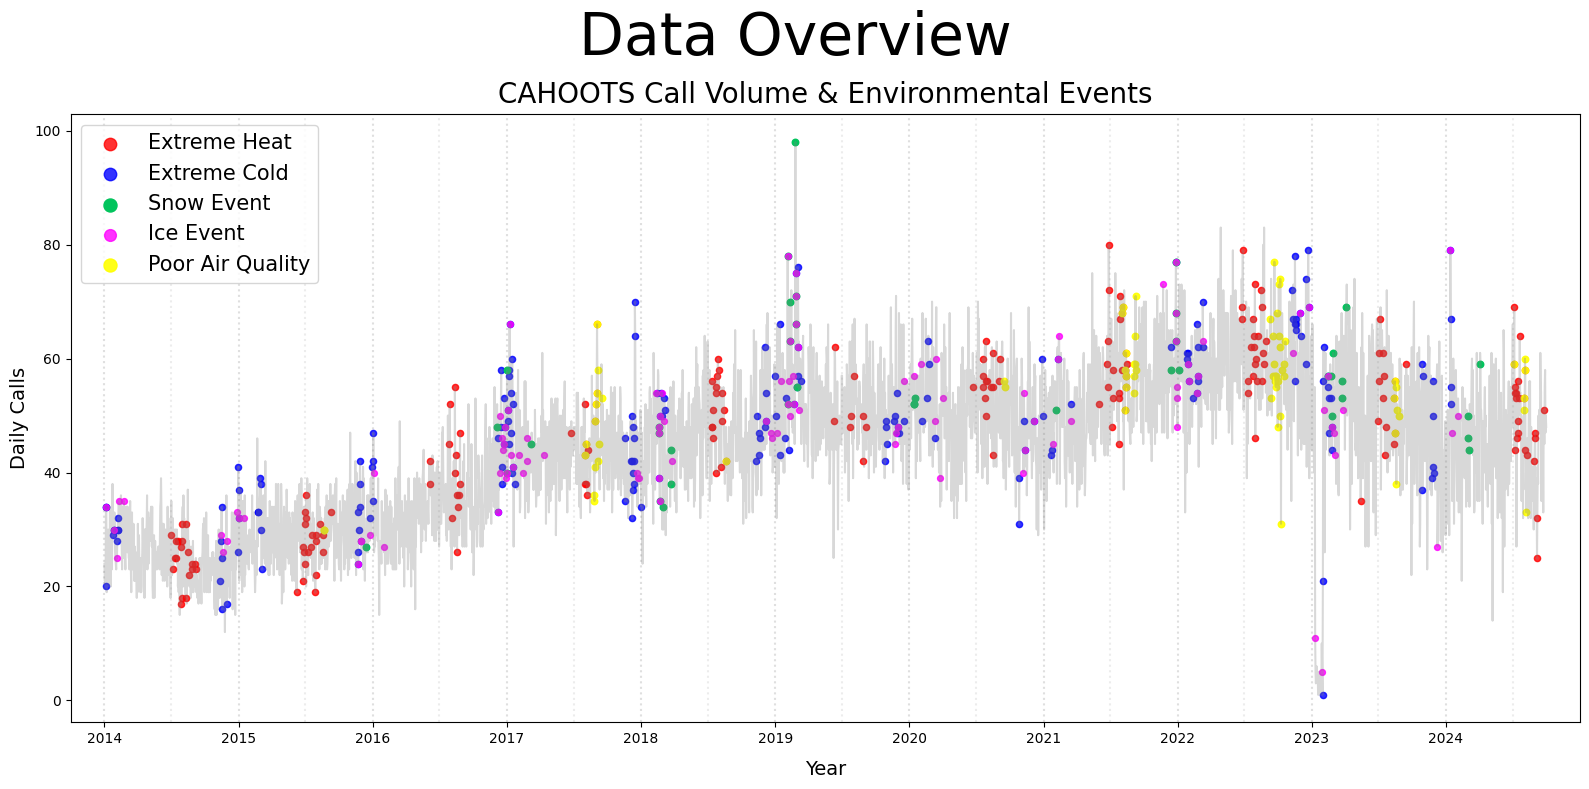

In [128]:
# TIME SERIES: daily calls, extreme events marked
fig, ax = plt.subplots(figsize=(16, 8))
#fig.patch.set_facecolor('black')
#ax.set_facecolor('#111111')

plt.plot(daily['Date'], daily['daily calls'], color='gray', alpha=0.30)

# year separator lines
for year in range(2014, 2025):  # 2014 to 2024
    plt.axvline(x=date(year, 1, 1), color='gray', linestyle=':', alpha=0.25)
# half-year:
for year in range(2014, 2025):  # 2014 to 2024
    plt.axvline(x=date(year, 7, 1), color='gray', linestyle=':', alpha=0.15)

# markers for extreme events
plt.scatter(daily[daily['extreme heat'] == 1]['Date'], # heat
            daily[daily['extreme heat'] == 1]['daily calls'], 
            color='red', label='Extreme Heat', marker='o', s=20, alpha=0.8)

plt.scatter(daily[daily['extreme cold'] == 1]['Date'], # cold
            daily[daily['extreme cold'] == 1]['daily calls'], 
            color='blue', label='Extreme Cold', marker='o', s=20, alpha=0.8)

plt.scatter(daily[daily['snow event'] == 1]['Date'], # snowstorm
            daily[daily['snow event'] == 1]['daily calls'], 
            color='#02c45d', label='Snow Event', marker='o', s=22, alpha=1)

plt.scatter(daily[daily['ice event'] == 1]['Date'], # icestorm
            daily[daily['ice event'] == 1]['daily calls'], 
            color='#FF00FF', label='Ice Event', marker='o', s=18, alpha=0.8)

plt.scatter(daily[daily['AQI hazard'] == 1]['Date'], # aqi
            daily[daily['AQI hazard'] == 1]['daily calls'], 
            color='yellow', label='Poor Air Quality', marker='o', s=22, alpha=0.9)

# ax = plt.gca()
# # Axis labels
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# # Tick labels
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# # Spine (axis border lines)
# for spine in ax.spines.values():
#     spine.set_color('white')
# # Title color
# ax.title.set_color('white')

# show month ticks on x axis: 3 month interval
plt.gca().xaxis.set_major_locator(mdates.YearLocator())#interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format as '2020'

plt.suptitle('Data Overview', fontsize=42, color='Black')

plt.title('CAHOOTS Call Volume & Environmental Events', fontsize=20, y=1.005)
plt.xlabel('Year', fontsize=14, labelpad=10)
plt.xlim(date(2013, 10, 1), date(2024, 12, 31))
plt.ylabel('Daily Calls', fontsize=14)

plt.legend(loc='upper left', 
          fontsize=15,
          markerscale=2,
          frameon=True,
          fancybox=True)
          #facecolor='lightgray')

plt.tight_layout()
plt.savefig("timeseries.png", dpi=300)
plt.show()

## 2. Correlations between continuous environmental variables and call volume

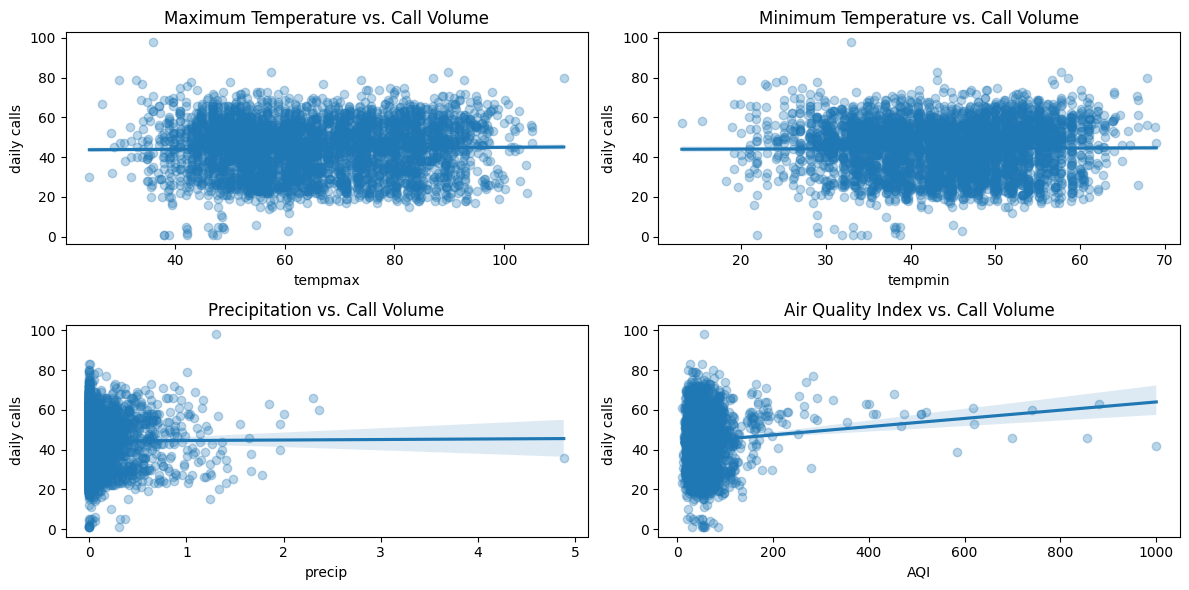

In [130]:
# correlations between CALL VOLUME and continuous environmental variables
corr_vars = ['daily calls', 'tempmax', 'tempmin', 'precip', 'snow', 'AQI']
correlation_matrix = daily[corr_vars].corr()

# scatterplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# tempmax
sns.regplot(x='tempmax', y='daily calls', data=daily, ax=axes[0, 0], scatter_kws={'alpha':0.3})
axes[0, 0].set_title('Maximum Temperature vs. Call Volume')

# temp min
sns.regplot(x='tempmin', y='daily calls', data=daily, ax=axes[0, 1], scatter_kws={'alpha':0.3})
axes[0, 1].set_title('Minimum Temperature vs. Call Volume')

# precip
sns.regplot(x='precip', y='daily calls', data=daily, ax=axes[1, 0], scatter_kws={'alpha':0.3})
axes[1, 0].set_title('Precipitation vs. Call Volume')

# AQI
sns.regplot(x='AQI', y='daily calls', data=daily, ax=axes[1, 1], scatter_kws={'alpha':0.3})
axes[1, 1].set_title('Air Quality Index vs. Call Volume')

plt.tight_layout()

plt.savefig("correlations.png", dpi=300)

plt.show()

## 3. CALL VOLUME Hypothesis testing: Is there a statistically significant difference between distributions of daily call volume during extreme vs. non extreme days for each type of environmental event?
### Using the **Mann Whitney U test**, because it:
- doesn't assume normal distributions
- works well with uneven sample sizes
- tests whether one group tends to have higher values than the other

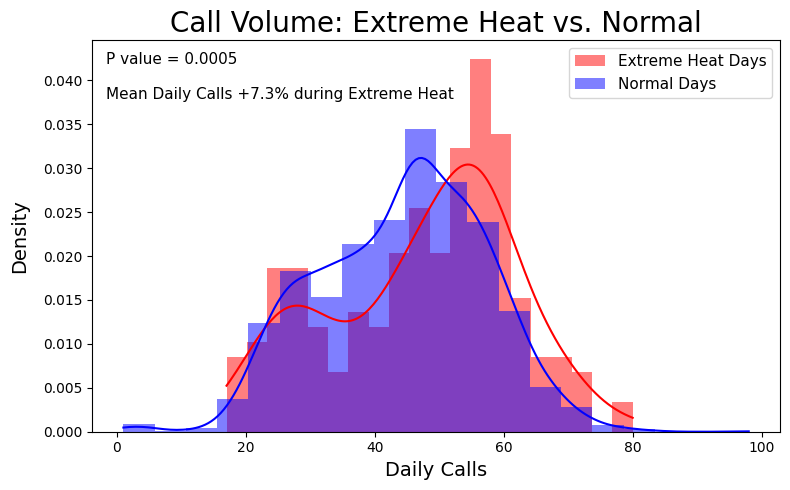

In [264]:
# function to do mann whitney u test for each environmental variable
def analyze_condition(daily_df, env_col):
    """
    Analyze call volume on days with vs. without an extreme environmental condition
    """    
    # Split data
    normal = daily_df[daily_df[env_col] == 0].sort_values('Date')
    extreme = daily_df[daily_df[env_col] == 1].sort_values('Date')


    fig, ax = plt.subplots(figsize=(8, 5))

    # Histogram of the data groups
    sns.histplot(extreme['daily calls'], stat='density', kde=True, color='red', edgecolor='none', label=f'{env_col.title()} Days', bins=20, alpha=0.5)
    sns.histplot(normal['daily calls'], stat='density', kde=True, color='blue', edgecolor='none', label='Normal Days', bins=20, alpha=0.5)
    ax.set_xlabel('Daily Calls', fontsize=14)
    ax.set_ylabel('Density', fontsize=14, labelpad=10)
    ax.set_title(f'Call Volume: {env_col.title()} vs. Normal', fontsize=20)
    ax.legend(fontsize=11)

    # Mann-Whitney U Test
    statistic, p_value = mannwhitneyu(extreme['daily calls'], normal['daily calls'])

    # Mean calculations
    mean_extreme = extreme['daily calls'].mean()
    mean_normal = normal['daily calls'].mean()
    pct_change = (mean_extreme / mean_normal - 1) * 100

    # Annotation text & pvalue formatting:
    if env_col == 'AQI hazard':
        p_text = f"{p_value:.11f}"
    elif env_col == 'snow event':
        p_text = f"{p_value:.6f}"
    else:
        p_text = f"{p_value:.4f}"
        
    annotation_text = f"P value = {p_text}\n\nMean Daily Calls +{pct_change:.1f}% during {env_col.title()}"
    ax.text(
        0.02, 0.97, annotation_text,
        transform=ax.transAxes,  # relative to axes
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='left',
        color='black'
    )

    plt.tight_layout()
    plt.savefig(f'{env_col.title().replace(" ", "")}Volume.png', dpi=300)  # remove spaces in filename
    plt.show()



# Run mann-whitney u test on each environmental variable:
envs = ['extreme heat']# 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
for variable in envs:
    analyze_condition(daily, variable)

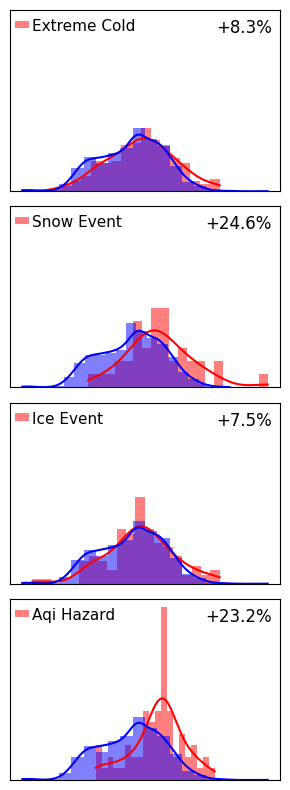

In [258]:
def minimal_subplot_visualization(daily_df, env_vars):
    fig, axes = plt.subplots(len(env_vars), 1, figsize=(3, 8), sharey=True)

    for ax, env_col in zip(axes, env_vars):
        normal = daily_df[daily_df[env_col] == 0]
        extreme = daily_df[daily_df[env_col] == 1]

        sns.histplot(extreme['daily calls'], stat='density', kde=True, color='red', edgecolor='none', bins=20, alpha=0.5, ax=ax)
        sns.histplot(normal['daily calls'], stat='density', kde=True, color='blue', edgecolor='none', bins=20, alpha=0.5, ax=ax)

        # small red legend patch inside axes
        box = patches.Rectangle((0.02, 0.9), 0.05, 0.04, transform=ax.transAxes,
                                facecolor='red', alpha=0.5, edgecolor='none')
        ax.add_patch(box)

        # Title text next to the box
        ax.text(0.08, 0.95, env_col.title(), transform=ax.transAxes, fontsize=11, va='top')

        # Calculate percent change
        mean_extreme = extreme['daily calls'].mean()
        mean_normal = normal['daily calls'].mean()
        pct_change = (mean_extreme / mean_normal - 1) * 100
        
        # Percent change written out
        ax.text(0.97, 0.95, f"+{pct_change:.1f}%", transform=ax.transAxes,
                fontsize=12, va='top', ha='right', color='black')
        
        # no ticks, labels, titles, legends
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        #ax.set_title(env_col.title(), fontsize=10)
    
    plt.tight_layout()
    plt.savefig("SmallVolumeSubplots.png", dpi=300)
    plt.show()

# loop thru all except heat:
envs = ['extreme cold', 'snow event', 'ice event', 'AQI hazard']
minimal_subplot_visualization(daily, envs)


### 3.1 RESULTS:
- Small p-values indicate a statistically significant difference in call volume during every extreme environmental event (versus on normal days)
- Call volume always seems to be skewed slightly _higher_ during environmental events than on normal days.
- This statistically significant difference in volume doesn't necessarily give us much information about how crisis _needs_ / the _types of calls_ differ during these events.

## 4. CATEGORICAL Call Type Analysis: Is the proportion of certain call categories (out of total calls) significantly higher during specific environmental extremes? 
(test if there is an association, and then whether certain proportions change significantly).

### 4.1 Using the **Chi Squared Test of Independence** to evaluate if there is an association, because it:
- compares whether distributions differ between two independent, **categorical** groups
- The Chi-square test of independence is a statistical hypothesis test used to determine whether two categorical or nominal variables are likely to be related or not.
- Chi squared test assumes independent observations, categorical data, and large enough sample sizes / intersections between categories (>5).
- In this case, the Chi squared test is testing this null hypothesis "There is no association between the environmental condition (i.e. extreme heat) and the distribution of call categories"

In [32]:
def run_chi_square_test(data, condition_col, label):
    '''
    chi squared test to test relationship between categorical variables' distributions, for each environmental variable

    data: data table
    condition_col: environmental conditions like extreme heat, etc.
    label: string for printing results

    Returns:
    observed counts of calltypes (contingency table)
    The expected counts under the assumption of independence
    prints:
    p-value degrees of freedom
    '''
    # Create contingency table: counts of each call type on extreme vs. non-extreme days
    contingency = pd.crosstab(data['nature'], data[condition_col])

    # do Chi2 test of independence
    # print table shape and min expected count check (chi2 assumptions)
    chi2, p, dof, expected = chi2_contingency(contingency)
    expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
    # Check assumptions
    min_expected = expected_df.min().min()
    too_small = (expected_df < 5).sum().sum()

    # print results
    print(f"{label.title()}: p-value of {p}\n")
    
    return contingency, expected_df


# Run chi2 test for each environmental event / extreme
print(f"Chi-Square Test Results:\n")
for cond, name in zip(['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard'],
                      ['Extreme Heat', 'Extreme Cold', 'Snow', 'Ice', 'Poor Air Quality']):
    run_chi_square_test(clean_data, cond, name)

Chi-Square Test Results:

Extreme Heat: p-value of 8.230583441825576e-49

Extreme Cold: p-value of 1.3099974744424027e-79

Snow: p-value of 1.0254507853850715e-07

Ice: p-value of 1.685626296481515e-45

Poor Air Quality: p-value of 1.935900754097227e-46



#### Extremely small p-values indicate that **the distribution of call categories changes significantly** during environmental extremes compared to normal days.

### 4.2 Follow-up visualizations to compare the proportions of _specific_ call categories that changed during extreme events:

In [35]:
# look at overall top call types
types = clean_data.groupby('nature').count()
types = types.sort_values('inci_id', ascending=False).head(10)
types

,Date,inci_id,AQI,AQI_Category,tempmax,tempmin,precip,snow,daily calls,extreme heat,extreme cold,snow event,ice event,AQI hazard
nature,,,,,,,,,,,,,,
PUBLIC ASSIST,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762,57762
WELFARE CHECK,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392,50392
TRANSPORT,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841,31841
SUICIDAL SUBJECT,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156,10156
INTOXICATED SUBJECT,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498
DISORDERLY SUBJECT,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813,2813
TRAFFIC HAZARD,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617,2617
FOUND SYRINGE,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403,2403
ASSIST FIRE DEPARTMENT,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926


<Figure size 1400x700 with 0 Axes>

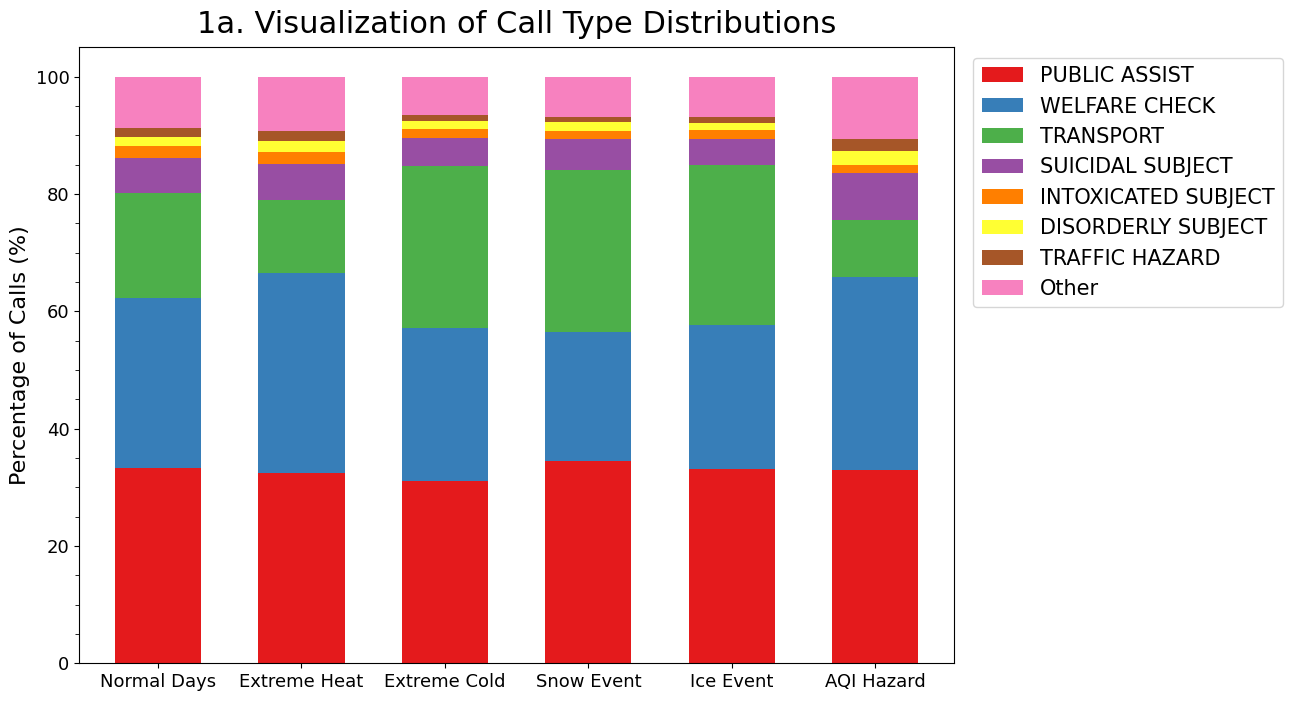

In [341]:
TOP_N = 7 # Number of top call types to show individually

# envs event columns & their display names
event_columns = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
display_names = ['Extreme Heat', 'Extreme Cold', 'Snow Event', 'Ice Event', 'AQI Hazard']

# Add "Normal" category at BEGINNING of list
event_columns_with_normal = event_columns.copy()
display_names_with_normal = display_names.copy()
event_columns_with_normal.insert(0,'normal')
display_names_with_normal.insert(0,'Normal Days')

# find overall top call types across all events
all_calls_count = clean_data['nature'].value_counts()
top_call_types = all_calls_count.nlargest(TOP_N).index.tolist()

# prepare data for plotting
results = {}


# FIRST, Add "Normal" days category (where all events are 0)
normal_days = clean_data[(clean_data['extreme heat'] == 0) & 
                         (clean_data['extreme cold'] == 0) & 
                         (clean_data['snow event'] == 0) & 
                         (clean_data['ice event'] == 0) & 
                         (clean_data['AQI hazard'] == 0)]

normal_call_counts = {}
for call_type in top_call_types:
    count = len(normal_days[normal_days['nature'] == call_type])
    normal_call_counts[call_type] = count

# 'other' category for normal days
other_normal_calls = normal_days[~normal_days['nature'].isin(top_call_types)]
normal_call_counts['Other'] = len(other_normal_calls)

# Add normal days to results
results['normal'] = normal_call_counts


# For each environmental event
for event in event_columns:
    # Get calls during event
    event_calls = clean_data[clean_data[event] == 1]
    
    call_counts = {}
    # Count top call types
    for call_type in top_call_types:
        count = len(event_calls[event_calls['nature'] == call_type])
        call_counts[call_type] = count
    
    # 'other' category (all call types not in top_call_types)
    other_calls = event_calls[~event_calls['nature'].isin(top_call_types)]
    call_counts['Other'] = len(other_calls)
    
    # Store results
    results[event] = call_counts



plot_data = pd.DataFrame(results).T  # Transpose so events are rows (for plotting)

# STACKED BARPLOT: show PERCENTAGES instead of counts
plot_data_pct = plot_data.copy()
plot_data_pct = plot_data_pct.astype(float) # resolve datatype error
for idx in plot_data_pct.index: # go through each event category
    total = plot_data_pct.loc[idx].sum()
    plot_data_pct.loc[idx] = plot_data_pct.loc[idx] / total * 100.0

# PERCENTAGE stacked bar plot
plt.figure(figsize=(14, 7))
sns.set_palette("Set1", n_colors=len(plot_data_pct.columns))
ax2 = plot_data_pct.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.6)

plt.title('1a. Visualization of Call Type Distributions', fontsize=22, y=1.01)
#plt.xlabel('Environmental Event', fontsize=16, labelpad=10)
plt.ylabel('Percentage of Calls (%)', fontsize=16)
plt.xticks(range(len(display_names_with_normal)), display_names_with_normal, rotation=0, ha='center', fontsize=13)

# legend outside the plot area
plt.legend(bbox_to_anchor=(1.01, 1),  # Position to the right of the plot
          loc='upper left',  # Anchor point of the legend
          fontsize=15,
          markerscale=2,
          frameon=True,
          fancybox=True)

plt.yticks(fontsize=13) # existing major ytick labels
ax2.set_yticks(range(0, 101, 5), minor=True) # minor ticks every 5%
ax2.tick_params(axis='y', which='minor', length=3) # minor ticks shorter

plt.subplots_adjust(right=0.75)  # Leave 25% space on right for legend
plt.savefig("stackedbars.png", dpi=300)
plt.show()

#### 4.2.1: findings from visualizations:

##### This bar chart above shows the percentage distribution of different call types during various types of environmental events & on normal days, based on data from the 11-year period.
##### It should be noted that there are more days classified as "Normal Days" than days with any extreme environmental event, so the total _raw number_ of calls on normal days is much higher.

##### From this visualization, we can see that the call types CAHOOTS most commonly responds to (no matter the weather conditions) are:
- PUBLIC ASSIST
- WELFARE CHECK
- TRANSPORT
- SUICIDAL SUBJECT
- INTOXICATED SUBJECT
- DISORDERLY SUBJECT
- TRAFFIC HAZARD
- the rest of the call categories are all small enough to be grouped together into an "other" category that makes up less than 10% of each bar's data

### 4.3 Test whether the proportion of _specific_ call types differs significantly between extreme-weather days and normal days, and report _how much_ it changed
### Using A **z-test for proportions**
- a Z-test is a statistical test for comparing the proportions from two populations, to see if the difference between them is statistically significant
- How it works: Calculates the absolute difference between the proportion of the call type during extreme & normal days, and determines whether that difference is likely due to chance based on the 2 sample sizes.
- For example, "Is the proportion of welfare check calls significantly higher during extreme heat? Can this be attributed to random chance?"
- A Z-test assumes independent, categorical observations across two groups 
### I will be evaluating the % changes of the **smaller subset of call types** (listed above) which are the most common across all the data-- on "normal" days and environmentally extreme days alike. This is because uncommon call types, even if they do increase/decrease by a statistically significant amount, are still extremely rare as shown in the bar chart above.

In [39]:
# test & print results for significance comparison of a single calltype and a single environmental event type
def test_call_type_proportions(data, call_type, env_condition_col, alpha=0.05):
    """
    Run z-test to see if the proportion of a specific call type changes during an environmental event
    
    data: clean_data
    call_type: call type to test
    env_condition_col: environmental condition column name
    alpha: significance level (p-value cutoff = 0.05)
    
    Returns dict with stats: counts, proportions, p-value, and significance
    """
    # Make sure call_type exists
    if call_type not in data['nature'].unique():
        raise ValueError(f"Call type '{call_type}' not found in data.")
    
    # filter for extreme days vs normal days
    extreme = data[data[env_condition_col] == 1]
    normal = data[data[env_condition_col] == 0]
    
    # Counts of the specific call type
    extreme_count = (extreme['nature'] == call_type).sum()
    normal_count = (normal['nature'] == call_type).sum()
    
    # Total calls (for calculating proportion)
    extreme_total = len(extreme)
    normal_total = len(normal)
    
    # proportions
    extreme_prop = extreme_count / extreme_total
    normal_prop = normal_count / normal_total
    
    # Z-test
    count = np.array([extreme_count, normal_count])
    nobs = np.array([extreme_total, normal_total])
    stat, p_value = proportions_ztest(count, nobs)
    
    # % change
    pct_change = ((extreme_prop / normal_prop) - 1) * 100 if normal_prop > 0 else np.nan
    
    return {
        'call_type': call_type,
        'env_condition': env_condition_col,
        'extreme_proportion': extreme_prop,
        'normal_proportion': normal_prop,
        'extreme_count': extreme_count,
        'normal_count': normal_count,
        'extreme_total': extreme_total,
        'normal_total': normal_total,
        'p_value': p_value,
        'significant': p_value < alpha,
        'pct_change': pct_change, 
        'percentage_point_diff': (extreme_prop - normal_prop) * 100, # measure the change in the composition of calls (the distribution shift)
        'extreme_prop_pct': extreme_prop * 100, # for clearer reporting
        'normal_prop_pct': normal_prop * 100
    }


# function to print the results
def print_ztest_results(results):
    change_direction = "increases" if results['pct_change'] > 0 else "decreases"
    
    print(f"Call type: {results['call_type']} during {results['env_condition']} days:")
    print(f"  Normal days: {results['normal_count']} calls out of {results['normal_total']} ({results['normal_prop_pct']:.2f}% of all calls)")
    print(f"  {results['env_condition']} days: {results['extreme_count']} calls out of {results['extreme_total']} ({results['extreme_prop_pct']:.2f}% of all calls)")
    print(f"  Change: {results['percentage_point_diff']:.2f} percentage points ({results['pct_change']:.1f}% relative change)")
    print(f"  p-value: {results['p_value']} - {'Significant' if results['significant'] else 'Not significant'}\n")

In [40]:
# go through my subset of call types, find significant and large percent change
def find_significant_changes(data, env_columns, alpha=0.05, min_pct_change=10):
    """
    Loop through all call types and environmental conditions to find significant changes over a certain % change
    
    data: clean_data
    env_columns: list of environmental conditions
    alpha: significance cutoff
    min_pct_change: minimum percent change to report
    
    Returns: List of results dictionaries for significant changes
    """
    significant_results = []
    
    # most-common subset of call types to test
    call_types = ['PUBLIC ASSIST', 'WELFARE CHECK', 'TRANSPORT', 'SUICIDAL SUBJECT', 'INTOXICATED SUBJECT', 'DISORDERLY SUBJECT', 'TRAFFIC HAZARD']

    # Loop through all combinations
    for call_type in call_types:
        for env_col in env_columns:
            try:
                # Run the test
                result = test_call_type_proportions(data, call_type, env_col, alpha)
                
                # Check if result is significant AND meets minimum percent change threshold
                if result['significant'] and (abs(result['pct_change']) >= min_pct_change):
                    significant_results.append(result)
                    
            except Exception as e:
                # Skip any combos that cause errors/insufficient data
                print(f"Error testing {call_type} for {env_col}: {e}")
                continue
    
    # Sort results by absolute percent change (largest first)
    significant_results.sort(key=lambda x: abs(x['pct_change']), reverse=True)
    
    return significant_results

# Function to print all significant results
def print_all_significant_results(results):
    if not results:
        print("No significant changes found meeting the criteria.")
        return
        
    print(f"Found {len(results)} significant changes:\n")
    for result in results:
        print_ztest_results(result)

In [41]:
# all environmental condition columns
env_condition_columns = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']

# Find significant changes with at least a 10% change
significant_changes = find_significant_changes(clean_data, env_condition_columns, alpha=0.05, min_pct_change=10)

# results:
print_all_significant_results(significant_changes)

Found 24 significant changes:

Call type: TRANSPORT during extreme cold days:
  Normal days: 29392 calls out of 165275 (17.78% of all calls)
  extreme cold days: 2449 calls out of 8854 (27.66% of all calls)
  Change: 9.88 percentage points (55.5% relative change)
  p-value: 2.5709616895414835e-121 - Significant

Call type: TRANSPORT during snow event days:
  Normal days: 31246 calls out of 171978 (18.17% of all calls)
  snow event days: 595 calls out of 2151 (27.66% of all calls)
  Change: 9.49 percentage points (52.2% relative change)
  p-value: 1.0542431521444009e-29 - Significant

Call type: TRANSPORT during ice event days:
  Normal days: 30427 calls out of 168942 (18.01% of all calls)
  ice event days: 1414 calls out of 5187 (27.26% of all calls)
  Change: 9.25 percentage points (51.4% relative change)
  p-value: 1.2381597681767208e-64 - Significant

Call type: TRANSPORT during AQI hazard days:
  Normal days: 31485 calls out of 170427 (18.47% of all calls)
  AQI hazard days: 356 ca

#### 4.3.1 Percent Change Interpretation:
- Percentage point change is the absolute difference between two percentages.
- Relative percentage change shows how much the original percentage has increased or decreased relative to itself.

EXAMPLE - WELFARE CHECK during AQI Hazard Days:
- During Poor AQI, welfare check calls make up an additional 4.16% of _all calls_ (a shift in the overall composition)
- The proportion of welfare check calls during poor AQI is 14.4% higher than itself on normal days (about 1.1 times more common)
- This means welfare check needs become only slightly more common during poor AQI

### 4.4 Visualization of the severity of call type proportion (%) changes during extreme environmental events:

In [44]:
# pct_change or percentage_point_diff represent different interpretations of cal type "change"

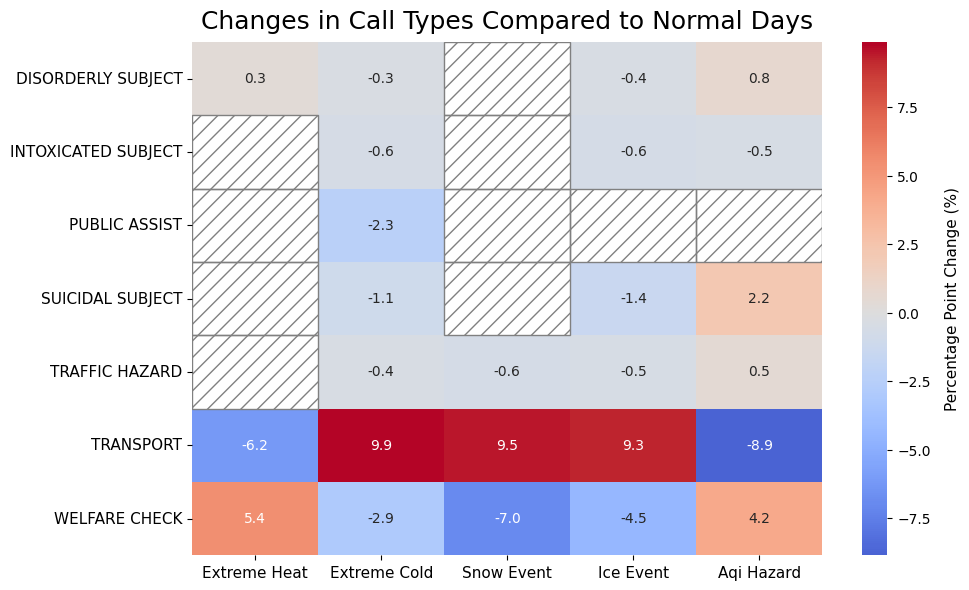

In [337]:
# list of call types and environmental conditions
call_types = ['PUBLIC ASSIST', 'WELFARE CHECK', 'TRANSPORT', 'SUICIDAL SUBJECT', 'INTOXICATED SUBJECT', 'DISORDERLY SUBJECT', 'TRAFFIC HAZARD']
env_conditions = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']

# run tests & collect the results
results = []

for call_type in call_types:
    for env_condition in env_conditions:
        # run z-test for significance
        result = test_call_type_proportions(clean_data, call_type, env_condition)
        
        # store entire result
        results.append({
            'call_type': call_type,
            'env_condition': env_condition,
            'percentage_point_diff': result['percentage_point_diff'], # or pct_change
            'significant': result['significant']
        })
            

# pivot to create our heatmap matrix
results_df = pd.DataFrame(results)
matrix_df = results_df.pivot(index='call_type', columns='env_condition', values='percentage_point_diff')
significance_matrix = results_df.pivot(index='call_type', columns='env_condition', values='significant')

# Convert to numeric to handle errors
matrix_df = matrix_df.apply(pd.to_numeric, errors='coerce')

# put columns in custom order
order = ['extreme heat', 'extreme cold', 'snow event', 'ice event', 'AQI hazard']
matrix_df = matrix_df[order]
significance_matrix = significance_matrix[order]
matrix_df.columns = matrix_df.columns.str.title()
significance_matrix.columns = significance_matrix.columns.str.title()

# PLOT HEATMAP:
plt.figure(figsize=(10, 6))
mask = ~significance_matrix # MASK to block out non-significant values
ax = sns.heatmap(matrix_df, 
                annot=True,
                fmt=".1f",
                cmap='coolwarm',
                center=0,
                mask=mask, # Mask non-significant values
                cbar_kws={'label': 'Percentage Change (%)'})

# colorbar customization
cbar = ax.collections[0].colorbar
cbar.set_label('Percentage Point Change (%)', labelpad=10, fontsize=11)

# shading for non-significant results
for i in range(len(call_types)):
    for j in range(len(env_conditions)):
        if mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='gray', 
                                      lw=1, hatch='//'))

plt.title('Changes in Call Types Compared to Normal Days', fontsize=18, y=1.01)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()

plt.savefig("calltypes_heatmap.png", dpi=300)

plt.show()

### 4.5 Summary of all Categorical Analysis Results:
A Chi-Square Test of Independence was conducted to determine whether the distribution of call categories differed between normal days and extreme environmental conditions. Results showed statistically significant _differences in call type distributions_ for extreme heat, extreme cold, snow, and poor air quality (p < 0.001 for all). This suggests that certain types of calls become more or less frequent during these environmental extremes, not due to random chance.

Then, I created visualizations of the proportions of different call types during each environmental event vs. normal days. I used this to identify the overall top/most common call types across all events.

Last, I used z-tests to test whether the proportion of those specific call types significantly changed during extreme-weather days compared to normal days. I looped through the call types during each type of environmental event, and found that many of them significantly changed (printings ones that changed by more than 10% for my understanding).

The heatmap plotted above shows the _percentage point changes_ of different call types during different environmental events (difference between the proportion of that call type on normal days vs. on days with that event). Call types that did not have _significance_, i.e. where the z-test found no significant change in proportion between extreme and normal days, have been shaded out.

## 5. Examining **case studies** of the most extreme environmental events:

By plotting call type percentage point changes to get a comprehensive overview of how crisis call categories changed during these particular events
I am looking at extreme heat, extreme cold, snow, and aqi hazards, because ice storms are a variable I engineered myself and thus there isn't a continuous 'ice storm' variable to find the most extreme occurence of.

In [48]:
# use the same functions above to calculate the statistics,
# and then make the big barplot of the 5 most severe events

In [49]:
def test_call_type_proportions_for_single_day(data, call_type, event_date, event_name, alpha=0.05):
    """
    Modified test_call_type_proportions(), to compare a specific day to all other days instead of using a binary column
    
    data: clean_data
    call_type: call type to test
    event_date: date of the extreme event
    event_name: name of event for labeling
    alpha: significance level
    
    Return dict with stats: counts, proportions, p-value, significance, and percent change
    """
    # Filter for event day vs. normal days
    event_day = data[data['Date'] == event_date]
    normal_days = data[data['Date'] != event_date]
    
    # Counts of the specific call type
    event_count = (event_day['nature'] == call_type).sum()
    normal_count = (normal_days['nature'] == call_type).sum()
    
    # Total calls (for calculating proportion)
    event_total = len(event_day)
    normal_total = len(normal_days)
    
    # Proportions
    event_prop = event_count / event_total
    normal_prop = normal_count / normal_total
    
    # Z-test
    count = np.array([event_count, normal_count])
    nobs = np.array([event_total, normal_total])
    stat, p_value = proportions_ztest(count, nobs)
    
    # % change
    pct_change = ((event_prop / normal_prop) - 1) * 100 if normal_prop > 0 else np.nan
    
    # return same type of dict w results:
    return {
        'call_type': call_type,
        'event': event_name,
        'event_proportion': event_prop,
        'normal_proportion': normal_prop,
        'event_count': event_count,
        'normal_count': normal_count,
        'event_total': event_total,
        'normal_total': normal_total,
        'p_value': p_value,
        'significant': p_value < alpha,
        'pct_change': pct_change, 
        'percentage_point_diff': (event_prop - normal_prop) * 100,
        'event_prop_pct': event_prop * 100,
        'normal_prop_pct': normal_prop * 100}

def analyze_extreme_event_days(data, event_dates, call_types=None):
    """
    To analyze all the extreme event days i defined ( most extreme)
    
    data: clean_data
    event_dates: Dictionary mapping event names to dates
    call_types: list of call types to analyze
    
    Return DataFrame with results for all event days and call types
    """
    
    all_results = []
    
    # Run test from func above for each event and call type
    for event_name, event_date in event_dates.items():
        for call_type in call_types:
            result = test_call_type_proportions_for_single_day(
                data, call_type, event_date, event_name
            )
            all_results.append(result)
    
    return pd.DataFrame(all_results)

# # Function to print results in a format similar to original output
# def print_single_day_results(results_df):
#     for _, row in results_df.iterrows():
#         change_direction = "increases" if row['pct_change'] > 0 else "decreases"
#         print(f"Call type: {row['call_type']} during {row['event']} day:")
#         print(f"  Normal days: {row['normal_count']} calls out of {row['normal_total']} ({row['normal_prop_pct']:.2f}% of all calls)")
#         print(f"  {row['event']} day: {row['event_count']} calls out of {row['event_total']} ({row['event_prop_pct']:.2f}% of all calls)")
#         print(f"  Change: {row['percentage_point_diff']:.2f} percentage points ({row['pct_change']:.1f}% relative change)")
#         print(f"  p-value: {row['p_value']} - {'Significant' if row['significant'] else 'Not significant'}\n")


C:\Users\hanna\AppData\Local\Temp\ipykernel_14740\2943942978.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, fontsize=15)


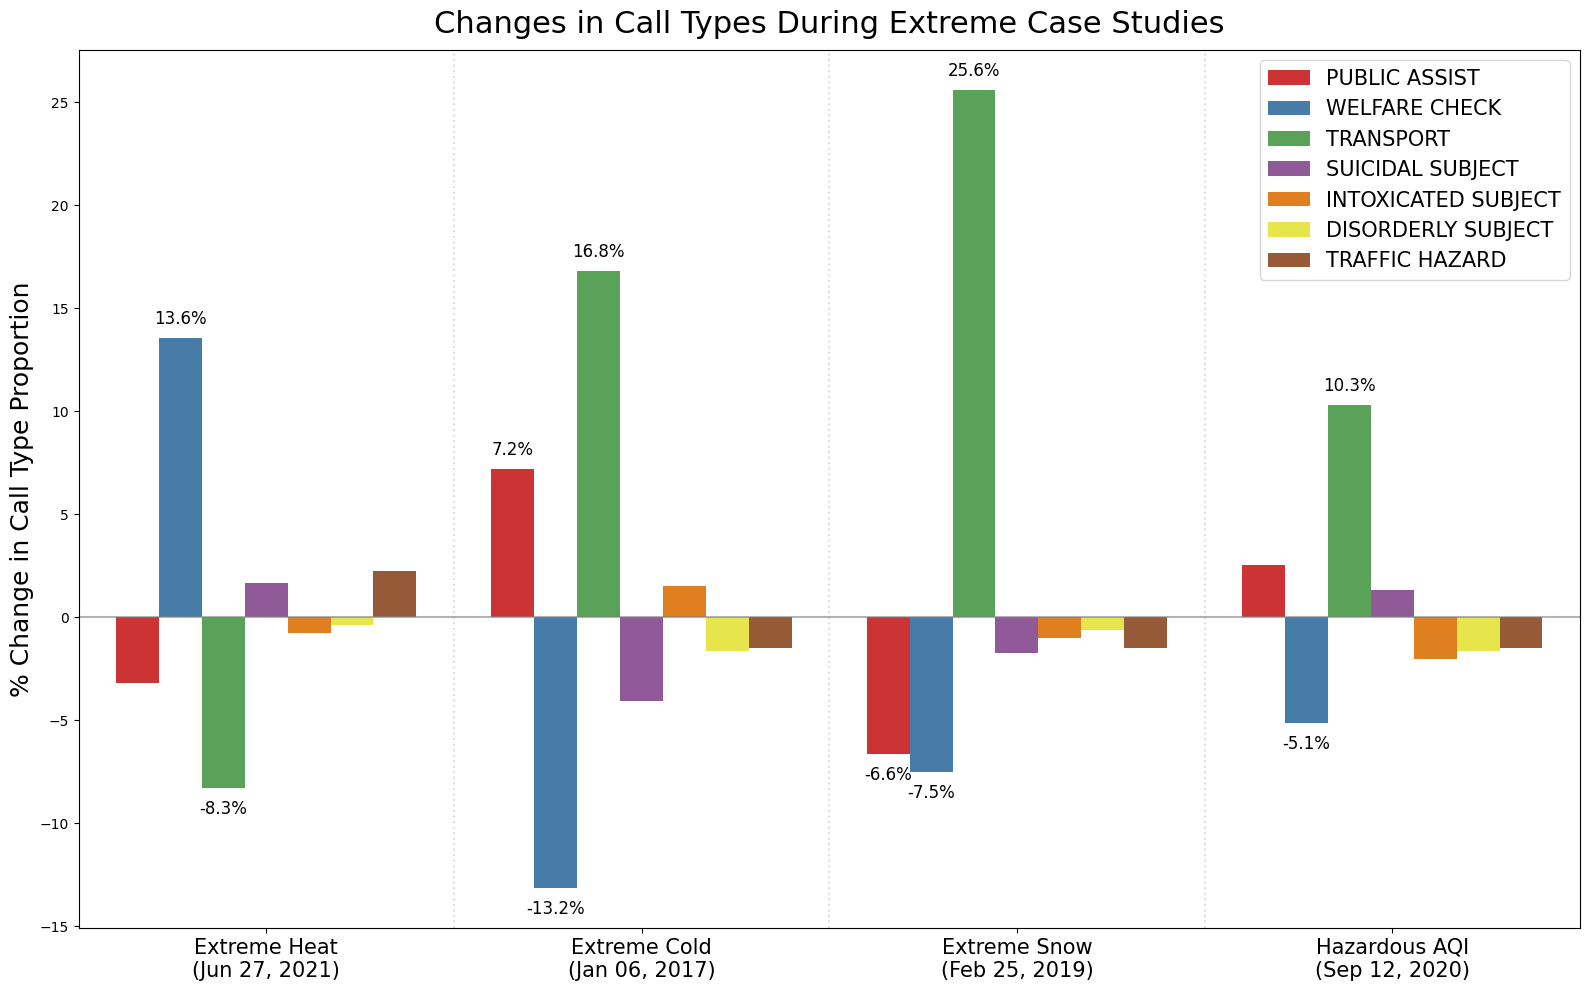

In [366]:
# run the analysis and plot for specific events:
extreme_heat_event = daily.sort_values('tempmax', ascending=False).reset_index().iloc[0,:]
extreme_cold_event = daily.sort_values('tempmin').reset_index().iloc[0,:]
extreme_snow_event = daily.sort_values('snow', ascending=False).reset_index().iloc[0,:]
extreme_aqi_event = daily.sort_values('AQI', ascending=False).reset_index().iloc[0,:]

heat_date = extreme_heat_event.loc['Date']
cold_date = extreme_cold_event.loc['Date']
snow_date = extreme_snow_event.loc['Date']
aqi_date = extreme_aqi_event.loc['Date']

# dict of event dates
event_dates = {
    'Extreme Heat': heat_date,
    'Extreme Cold': cold_date, 
    'Extreme Snow': snow_date,
    'Hazardous AQI': aqi_date
}

# call types to analyze (subset!)
call_types = ['PUBLIC ASSIST', 'WELFARE CHECK', 'TRANSPORT', 'SUICIDAL SUBJECT', 'INTOXICATED SUBJECT', 'DISORDERLY SUBJECT', 'TRAFFIC HAZARD']

# analysis:
results_df = analyze_extreme_event_days(clean_data, event_dates, call_types)

# Print results similar to the original EDA format
# print("Results for extreme event days:\n")
# print_single_day_results(results_df)



# GROUPED BARPLOT:
plt.figure(figsize=(16, 10))
sns.set_palette("Set1", n_colors=len(plot_data_pct.columns))
ax = sns.barplot(
    x='event', 
    y='percentage_point_diff', # or use pct_change for different interpretation
    hue='call_type', 
    data=results_df
)

# actual dates for each event to add to labels
event_dates_formatted = {
    'Extreme Heat': heat_date.strftime('%b %d, %Y'),
    'Extreme Cold': cold_date.strftime('%b %d, %Y'),
    'Extreme Snow': snow_date.strftime('%b %d, %Y'),
    'Hazardous AQI': aqi_date.strftime('%b %d, %Y')}

# x-axis tick labels with dates
x_labels = [f"{event}\n({event_dates_formatted[event]})" for event in results_df['event'].unique()]
ax.set_xticklabels(x_labels, fontsize=15)

plt.title('Changes in Call Types During Extreme Case Studies', fontsize=22, y=1.01)
plt.xlabel('')
plt.ylabel('% Change in Call Type Proportion', fontsize=18)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.6)  # horizontal line at 0


# event separator lines
plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.25)
plt.axvline(x=1.5, color='gray', linestyle=':', alpha=0.25)
plt.axvline(x=2.5, color='gray', linestyle=':', alpha=0.25)


# legend
plt.legend(loc='best', 
          fontsize=15,
          markerscale=2,
          frameon=True,
          fancybox=True)

# labels on the bars
for i, bar in enumerate(ax.patches):
    if abs(bar.get_height()) > 5:
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            bar.get_height() + (0.7 if bar.get_height() > 0 else -1.25),
            f'{bar.get_height():.1f}%',
            ha='center', 
            fontsize=12
        )
plt.tight_layout()

plt.savefig("casestudies.png", dpi=300)

plt.show()